## Multirun experiment pipeline (HydroShoot)

The following notebook establishes a generalized pipeline for evaluating a computing reservoir against a given task, given multiple experimental runs of the same reservoir.


In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

### Importing the dataset

In [2]:
from src.model.rc_dataset import ExperimentDataset

csv_path = '../datasets/hydroshoot_large_trimmed.csv'
dataset = ExperimentDataset(csv_path=csv_path)
print(dataset)

Dataset properties:
	n_runs:      84
	n_steps:    168
	state_size: 360

Available targets: 
	input_Tac, input_u, input_hs, input_Rg, output_Rg, output_An, output_E, output_Tleaf

Available state variables: 
	state_An, state_E, state_Eabs, state_Ei, state_Flux, state_FluxC, state_Tlc, state_gb, state_gs, state_psi_head, state_u



### Target definition

- A target is defined as a transformation of a series.
- A target generator yields all transformed signals for all runs.


In [3]:
def direct_target_generator(dataset: ExperimentDataset, target: str, run_ids: [int]):
  """Returns a function that generates the target from the run id."""
  assert target in dataset.get_targets(), f"{target} not available in dataset."

  # preload data in numpy array for performance reasons
  data = np.empty((len(run_ids), dataset.n_steps()))
  for run_id in run_ids:
    data[run_id, :] = dataset.get_target(target, run_id).to_numpy()

  for run_id in run_ids:
    yield data[run_id, :]

target_generator = direct_target_generator(dataset, 'input_Tac', [0, 1])
print(next(target_generator).shape)

(168,)


### Reservoir definition

- A reservoir is defined as a transformation of the dataset state.
- A reservoir generator returns a function that yields the state data for a run id.

In [4]:
def direct_reservoir_generator(dataset: ExperimentDataset, state_var: str, run_ids: [int], state_size=-1, random_state=None):
  """Returns a function that generates the reservoir from the run id."""
  assert state_var in dataset.get_state_variables(), f"{state_var} not available in dataset."

  if state_size > 0:
    if random_state is not None:
      np.random.seed(random_state)
    state_choice = np.random.choice(dataset.state_size(), size=state_size, replace=False)
  else:
    state_choice = slice(0, dataset.state_size())

  for run_id in run_ids:
    yield dataset.get_state(state_var, run_id)[:, state_choice]
  

reservoir_generator = direct_reservoir_generator(dataset, 'state_Tlc', [0, 1], state_size=16, random_state=42)
print(next(reservoir_generator).shape)

(168, 16)


### Data preprocessing

Preprocessing performed: 

1. A random subsample of observation nodes is selected.
2. The target signal for each run is computed.
3. Target and reservoir are cast into a ndarray.
4. Target and reservoir signals are trimmed.
   - A warmup mask is applied to target and reservoir.
   - A night-time mask is applied to target and reservoir.
5. Target and reservoir are rescaled to zero-mean and unit variance
   - Normalizing transform is fitted on the entire dataset of included experiment runs.

In [5]:
def get_state_random_subset(state: pd.DataFrame, state_size: int) -> pd.DataFrame:
  choice = np.random.choice(state.shape[1], size=state_size, replace=False)
  return state.iloc[:, choice]


def preprocess_data(dataset, run_ids, target_generator, reservoir_generator,  
                    state_size=32, warmup_steps=0, day_mask=None):
  # 1. Take a random subsample of observation nodes
  state_choice = np.random.choice(dataset.state_size(), size=state_size, replace=False)
  
  # 2. Cast target and reservoir state into NumPy ndarrays.
  X = np.empty((len(run_ids), dataset.n_steps(), state_size)) # shape (runs, time_steps, nodes)
  y = np.empty((len(run_ids), dataset.n_steps()))             # shape (runs, time_steps)
  
  for i_run, run_state in enumerate(reservoir_generator):
    X[i_run, :, :] = run_state[:, state_choice]
    
  for i_run, run_target in enumerate(target_generator):
    y[i_run, :] = run_target

  # 3. Masks are applied.
  if day_mask is None: 
    time_mask = np.ones(X.shape[1], dtype=bool)
  else:
    n_days = X.shape[1] // len(day_mask)
    assert dataset.n_steps() % len(day_mask) == 0, "Dataset time steps must be multiple of day mask."
    time_mask = np.tile(day_mask, n_days) 
  
  time_mask[:warmup_steps] = False
  X = X[:, time_mask, :]
  y = y[:, time_mask]

  # 4. Normalize target and reservoir states
  X = (X - X.mean()) / X.std()
  y = (y - y.mean()) / y.std()

  return X, y

#### Preprocessing decisions

- For now, keep all runs
- Discard first 4 days of each simulation
- Discard 22pm-5am

In [6]:
from src.learning.preprocessing import generate_mask


RUN_IDS = np.arange(dataset.n_runs())
WARMUP_STEPS = 4 * 24
DAY_MASK = generate_mask(5, 21)

STATE_SIZE = 16

TARGET = 'input_Tac'
STATE_VAR = 'state_An'

In [7]:
target_generator = direct_target_generator(dataset, TARGET, RUN_IDS)
reservoir_generator = direct_reservoir_generator(dataset, STATE_VAR, RUN_IDS)

np.random.seed(42)

X, y = preprocess_data(dataset, RUN_IDS, target_generator, reservoir_generator, state_size=STATE_SIZE,  warmup_steps=WARMUP_STEPS, day_mask=DAY_MASK)

print(X.shape)
print(y.shape)              

(84, 48, 16)
(84, 48)


### Grouping

Simulation state from the same calendar day of simulation inputs, across all runs, are grouped together per day.

```
GROUP 1 | GROUP 2 | GROUP 3 | GROUP 4 | ...
--------+---------+---------+---------+----
sim1/d1  sim1/d2   sim1/d3   /         /
/        sim2/d2   sim2/d3   sim2/d4   /
         /         sim3/d3   sim3/d4   sim3/d5
                               ...
```

In [8]:
def group_by_day(X: np.ndarray, days_per_run, offset_between_runs=1) -> np.ndarray:
  """Generates an array of group indices for state X.
  - Shape of X is assumed to be (runs, time_steps, nodes)
  """
  n_runs, n_steps, n_nodes = X.shape
  assert n_steps % days_per_run == 0, "steps per run must be an integer multiple of days_per_run."
  steps_per_day = n_steps // days_per_run

  groups = np.empty((n_runs, n_steps))

  offset = 0
  for i_run in range(n_runs):
    groups[i_run, :] = np.arange(offset, offset + days_per_run).repeat(steps_per_day)
    offset += offset_between_runs

  return groups

In [9]:
days_per_run = X.shape[1] // DAY_MASK.sum()
groups = group_by_day(X, days_per_run)

print(groups.shape)

(84, 48)


### Train-test splitting

Now that the data is grouped, we can flatten the runs into a single dataset.



In [10]:
X_flat = X.reshape((-1, X.shape[-1]))
y_flat = y.reshape((-1))
groups_flat = groups.reshape((-1))

print(f'     X flat: {X_flat.shape}')
print(f'     y flat: {y_flat.shape}')
print(f'groups flat: {groups_flat.shape}')

     X flat: (4032, 16)
     y flat: (4032,)
groups flat: (4032,)


- Train-test splitting is done at group scope (i.e. by calendar day)
- Training and testing ranges are chosen as contiguous blocks rather than randomly selected.

e.g. for `interval_length = 8` and `test_ratio = 0.25`, the consecutive groups are assigned as follows:

```
g1     g2      g3      g4      g5      g6      g7     g8                   
------+-------+-------+-------+-------+-------+------+------+
Train | Train | Train | Train | Train | Train | Test | Test | ... (repeat)
```

In [11]:
def train_test_split_blocks(X, y, groups, test_ratio=0.25, interval_length=16):
  """
  - Train-test splitting is done at group scope (i.e. by calendar day)
  - Training and testing ranges are chosen as contiguous blocks rather 
    than randomly selected.

  e.g. for `interval_length = 8` and `test_ratio = 0.25`, 
  the consecutive groups are assigned as follows:

  g1     g2      g3      g4      g5      g6      g7     g8                   
  ------+-------+-------+-------+-------+-------+------+------+
  Train | Train | Train | Train | Train | Train | Test | Test | ... (repeat)
  """
  X_flat = X.reshape((-1, X.shape[-1]))
  y_flat = y.reshape((-1))
  groups_flat = groups.reshape((-1))

  group_ids = np.unique(groups_flat)

  test_run_length = np.ceil(INTERVAL_LENGTH * TEST_RATIO).astype(int)
  train_run_length = INTERVAL_LENGTH - test_run_length

  split_mask = np.empty((INTERVAL_LENGTH), dtype=bool)
  split_mask[0:train_run_length] = True
  split_mask[train_run_length:INTERVAL_LENGTH] = False
  split_mask = np.tile(split_mask, np.ceil(len(group_ids) / INTERVAL_LENGTH).astype(int))[:len(group_ids)]

  groups_train = group_ids[split_mask]
  groups_test = group_ids[~split_mask]

  train_idx = np.where(np.in1d(groups_flat, groups_train))
  X_train = X_flat[train_idx]
  y_train = y_flat[train_idx]
  groups_train = groups_flat[train_idx]

  test_idx = np.where(np.in1d(groups_flat, groups_test))
  X_test = X_flat[test_idx]
  y_test = y_flat[test_idx]
  groups_test = y_flat[test_idx]

  return (X_train, y_train, groups_train), (X_test, y_test, groups_test)


In [67]:
TEST_RATIO = 0.5
INTERVAL_LENGTH = 8

(X_train, y_train, groups_train), (X_test, y_test, groups_test) = train_test_split_blocks(X, y, groups, TEST_RATIO, INTERVAL_LENGTH)

print(f'X_train shape:      {X_train.shape}')
print(f'y_train shape:      {y_train.shape}')
print(f'groups_train shape: {groups_train.shape}')
print(f'X_test shape:       {X_test.shape}')
print(f'y_test shape:       {y_test.shape}')
print(f'groups_test shape:  {groups_test.shape}')



X_train shape:      (2064, 16)
y_train shape:      (2064,)
groups_train shape: (2064,)
X_test shape:       (1968, 16)
y_test shape:       (1968,)
groups_test shape:  (1968,)


### Model definition

- Readout model is a standard RidgeRegression model with intercept term and CV-tuned regularization strength $\alpha$.
- CV search grid is a progression of logarithmicly spaced values for regularization strength $\alpha$.
- CV and testing metric is NMSE.

In [68]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

from src.learning.scorers import nmse_scorer


N_FOLDS = 5;


# Define model
readout = Pipeline([
  ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

# define search grid
search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-3), np.log10(1e3), 50)
}]

# define cross-validation and testing metric
scorer = nmse_scorer

# Define CV fold strategy
folds = GroupKFold(n_splits=N_FOLDS)

### Readout training

Regularization strength is tuned using a grid search.

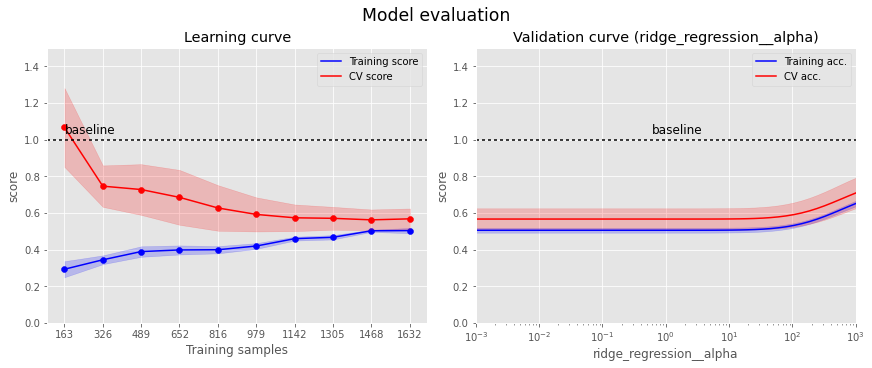

In [69]:
%reload_ext autoreload
%autoreload 2 

from figures import learning_validation_curves

param_name = 'ridge_regression__alpha'
param_range = 10 ** np.linspace(np.log10(1e-3), np.log10(1e3), 50)

learning_validation_curves(readout, X_train, y_train, groups_train, folds, scorer, param_name, param_range)

In [70]:
from src.learning.training import perform_gridsearch

model, _ = perform_gridsearch(readout, X_train, y_train, groups_train, folds, search_grid, verbose=True)

test_score = -scorer(model, X_test, y_test)
print(f'\nNMSE on test set: {test_score:.4f}')

Cross-validation scores after tuning:
  - Train: -0.5055 +/- 0.01323
  - CV:    -0.5666 +/- 0.05858
Optimal hyperparameters:
  - ridge_regression__alpha = 2.023589647725158

NMSE on test set: 0.4773
